## Check the pages with DINO

In [3]:
import torch
import numpy as np
import SimpleITK as sitk
import pandas as pd
import torchio as tio
import torch.nn as nn
import ast
import copy
import os
import shutil
import matplotlib.pyplot as plt
from model import VitGenerator
from utils import preprocess_data

/home/domainHomes/tian/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/domainHomes/tian/miniconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [18]:
def case_names(case_num=12):
    labels_dir = "../Alex/try_2.csv"
    labels_df = pd.read_csv(labels_dir)
    names = labels_df["StudyUID"].tolist()[:case_num]
    slice_nums = labels_df["predict_slice"].tolist()[:case_num]
    return names,slice_nums

In [19]:
def visualize_attention(model, img, patch_size=8, device="cuda"):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # number of head
    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    return attentions

In [20]:
def predict(names,slice_nums,view="sagittal"):
    case_tensors = []
    attentions = []
    for i, name in enumerate(names):
        # Load the saved model
        device = 'cuda' if torch.cuda.is_available() else 'cpu'  
        model = VitGenerator(name_model='vit_base', patch_size=8, 
                        device=device, evaluate=True, checkpoint="first_try_with_one_loss")

        # Load the test data and apply transforms
        case_path = f'../../previous_dataset/Preprocessed_dataset_2/{name}/{view.upper()}_PROTON.nii'
        case_tensor = preprocess_data(case_path,slice_nums[i]).to(device)

        # Make predictions on the test data
        with torch.no_grad():
            attention = visualize_attention(model, case_tensor)
        
        case_tensors.append(case_tensor.cpu().numpy())
        attentions.append(attention)
    return case_tensors,attentions

In [5]:
def plot_attention_original(case_tensors, attentions):
    for i, case_tensor in enumerate(case_tensors):
        img = case_tensor[0]
        attention = attentions[i]
        n_heads = attention.shape[0]
        print(n_heads)

        plt.figure(figsize=(10, 10))
        text = ["Original Image", "Head Mean"]
        for i, fig in enumerate([img, np.mean(attention, 0)]):
            plt.subplot(1, 2, i+1)
            plt.imshow(fig, cmap='inferno')
            plt.title(text[i])
        plt.show()

In [21]:
def plot_attention(case_tensors,attentions):
    n_rows = int(len(case_tensors)/2)
    fig,axes = plt.subplots(nrows=n_rows,ncols=4,figsize=(20,20))
    plt.axis('off')

    for i, case_tensor in enumerate(case_tensors):
        if i % 2 == 0:
            col_n = 0
        else:
            col_n = 1
        img = case_tensor[0]
        attention = attentions[i]
        n_heads = attention.shape[0]
        axes[i//2,2*col_n].imshow(img,cmap='gray')
        axes[i//2,2*col_n+1].imshow(np.mean(attention, 0),cmap='inferno')

    plt.show()


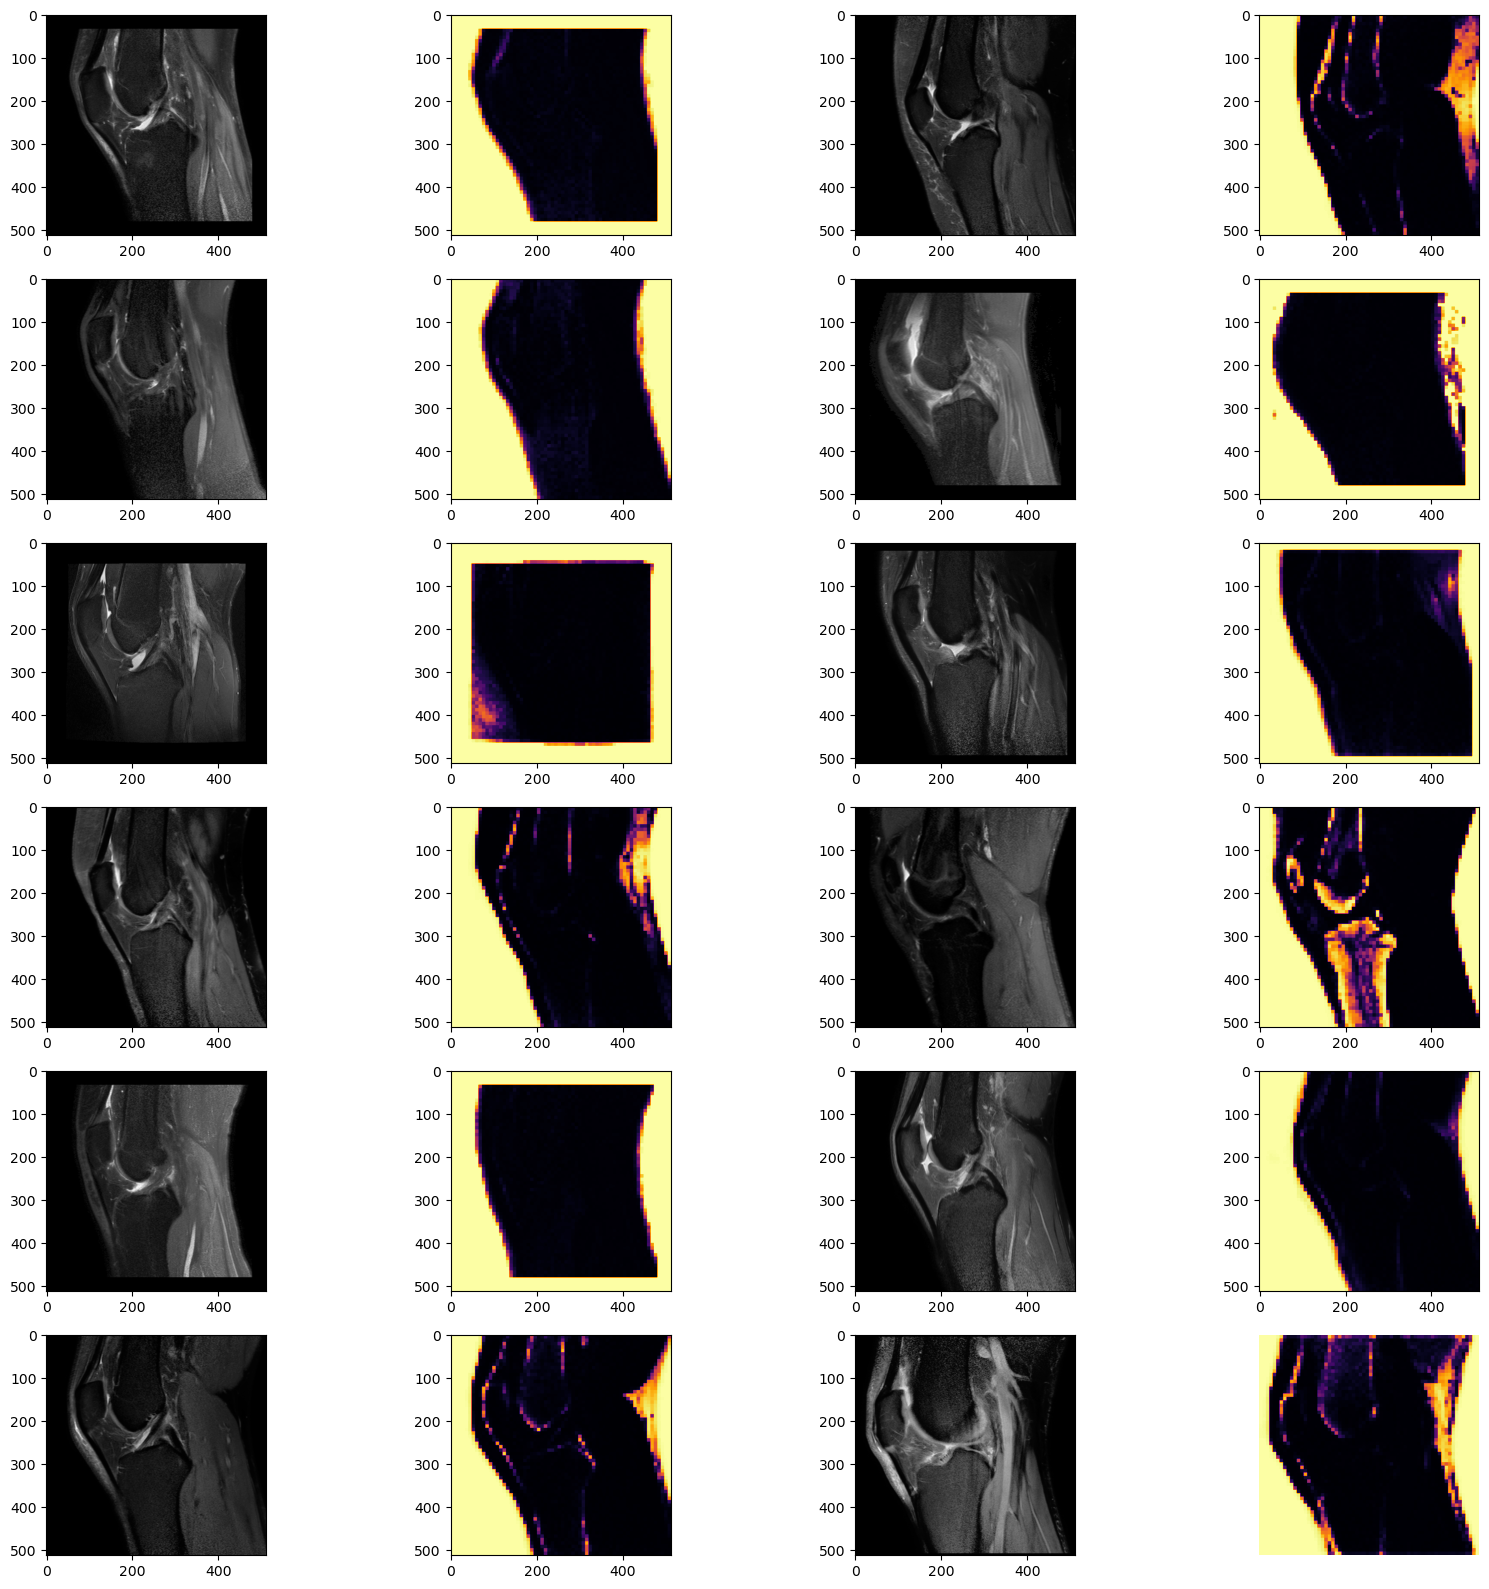

In [22]:
names,slice_nums = case_names()
case_tensors,attentions = predict(names,slice_nums)
plot_attention(case_tensors,attentions)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import ast
import matplotlib.pyplot as plt
import pandas as pd
from model import VitGenerator
from utils import preprocess_data

def case_names(case_num=10):
    label = pd.read_csv("../Alex/try_2.csv")
    label_acl = label[~label["sagittal_location"].isnull()]
    names = label_acl["StudyUID"].tolist()[:case_num]
    locations = label_acl["sagittal_location"].tolist()[:case_num]
    slice_nums = []
    pixel_locations = []
    for location in locations:
        location = ast.literal_eval(location)
        slice_nums.append(location[2])
        location = (location[0],location[1])
        pixel_locations.append(location)
    return names,slice_nums,pixel_locations

/home/domainHomes/tian/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def create_gaussian_image(center_x, center_y, radius=10, width=512, height=512):
    image = np.zeros((height, width))
    
    for y in range(height):
        for x in range(width):
            distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            gaussian_value = np.exp(-(distance**2) / (2 * (radius**2)))
            image[y,x] = gaussian_value
    
    max_value = np.max(image) # normalization
    image /= max_value
    image = torch.from_numpy(image).to("cuda")
    return image

In [3]:
def visualize_attention(model, img, patch_size=8, device="cuda"):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # number of head
    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    return attentions

In [4]:
def predict(names,slice_nums,view="sagittal"):
    case_tensors = []
    attentions = []
    for i, name in enumerate(names):
        # Load the saved model
        device = 'cuda' if torch.cuda.is_available() else 'cpu'  
        model = VitGenerator(name_model='vit_base', patch_size=8, 
                        device=device, evaluate=True, checkpoint="second_try_with_two_loss(selfsetting)") #"2023-06-01_15-08"

        # Load the test data and apply transforms
        case_path = f'../../previous_dataset/Preprocessed_dataset_2/{name}/{view.upper()}_PROTON.nii'
        case_tensor = preprocess_data(case_path,slice_nums[i]).to(device)

        # Make predictions on the test data
        with torch.no_grad():
            attention = visualize_attention(model, case_tensor)
        
        case_tensors.append(case_tensor.cpu().numpy())
        attentions.append(attention)
    return case_tensors,attentions

In [6]:
# if torch.device("cuda"):
#     torch.cuda.set_device(1)

names,slice_nums,pixel_locations = case_names()

gaussian_images = []
for pixel_location in pixel_locations:
    gaussian_image = create_gaussian_image(pixel_location[0],pixel_location[1])
    gaussian_images.append(gaussian_image.detach().cpu().numpy())

case_tensors,attentions = predict(names,slice_nums)

AssertionError: Torch not compiled with CUDA enabled

In [6]:
def plot(case_tensors,gaussian_images,attentions):
    nrow = len(case_tensors)
    fig,axes = plt.subplots(nrows=nrow,ncols=4,figsize=(16,4*nrow))
    row = 0
    for i, case_tensor in enumerate(case_tensors):
        axes[row,0].imshow(case_tensor[0],cmap="gray")
        axes[row,1].imshow(gaussian_images[i],cmap="gray")
        axes[row,2].imshow(case_tensor[0], cmap='gray',alpha=0.7)
        axes[row,2].imshow(gaussian_images[i], cmap='inferno',alpha=0.3)
        axes[row,3].imshow(np.mean(attentions[i],0),cmap="inferno")
        row += 1
    plt.show()

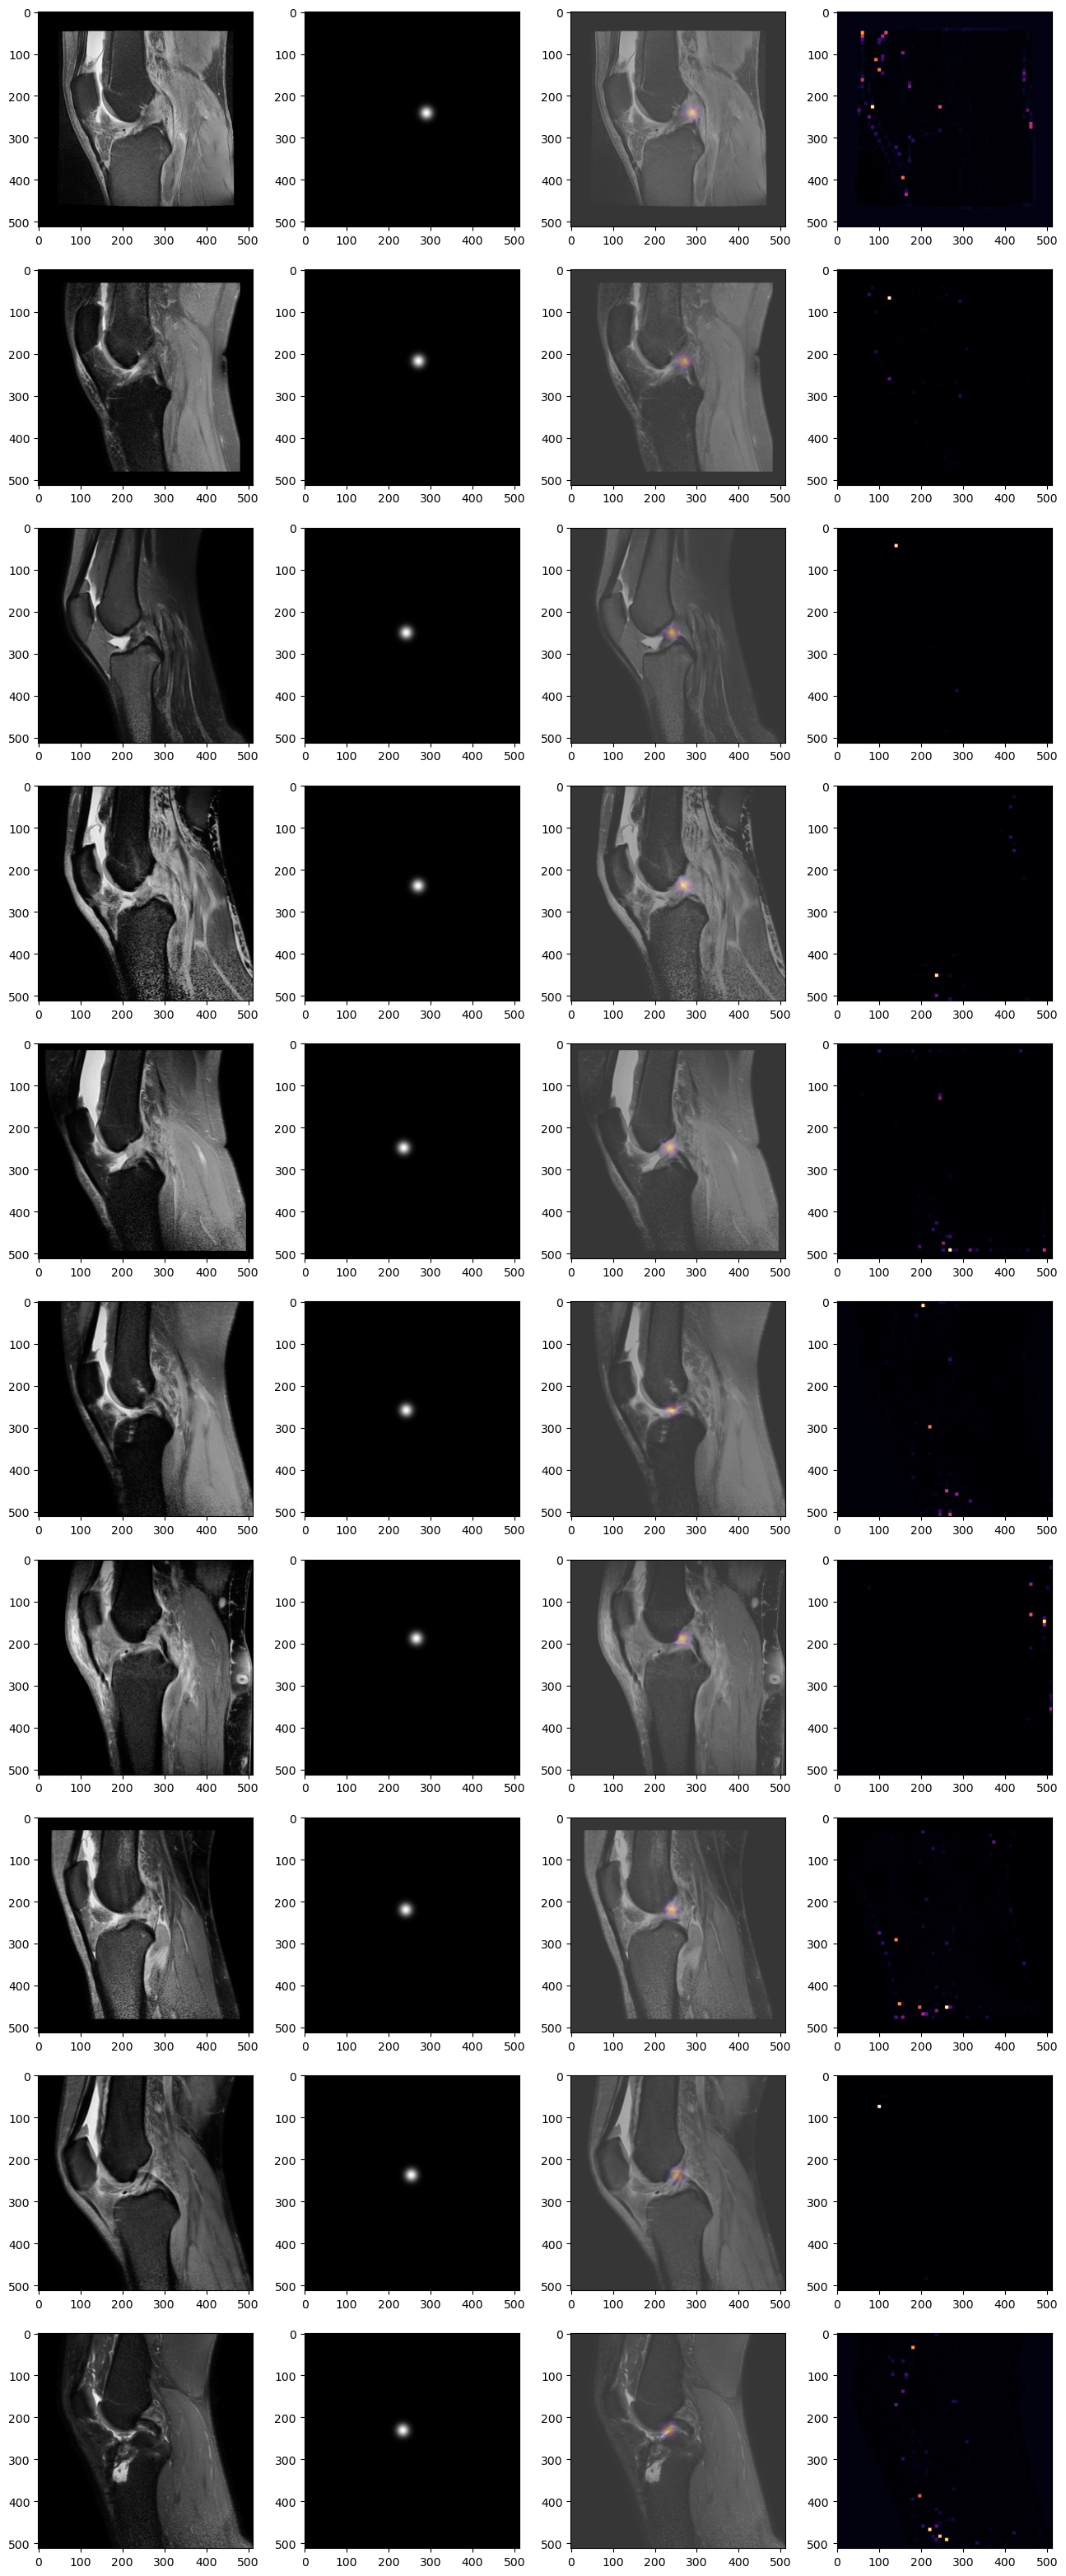

In [11]:
plot(case_tensors,gaussian_images,attentions)

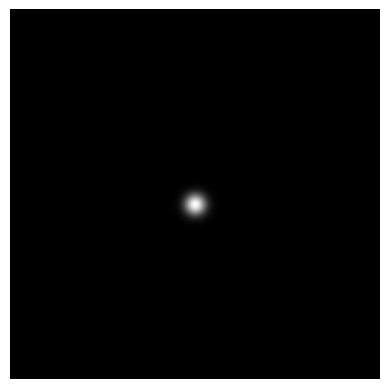

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def create_gaussian_image(center_x, center_y, radius=10, width=512, height=512):
    image = np.zeros((height, width))
    
    for y in range(height):
        for x in range(width):
            distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            gaussian_value = np.exp(-(distance**2) / (2 * (radius**2)))
            image[y,x] = gaussian_value
    
    max_value = np.max(image) # normalization
    image /= max_value

    fig,ax = plt.subplots()
    ax.imshow(image, cmap="gray")
    ax.axis('off')
    ax.set_title('')
    plt.savefig('gaussian_ball.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)
    return 

create_gaussian_image(256,270)

## Dino V2

In [1]:
import numpy as np
import torch
import cv2
import os
import torchvision.transforms as T
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.nn as nn
import ast
import matplotlib.pyplot as plt
import pandas as pd
from model import VitGenerator
from utils import preprocess_data
from PIL import Image
from sklearn.decomposition import PCA

def case_names(case_num=4):
    label = pd.read_csv("../Alex/try_2.csv")
    label_acl = label[~label["sagittal_location"].isnull()]
    names = label_acl["StudyUID"].tolist()[:case_num]
    locations = label_acl["sagittal_location"].tolist()[:case_num]
    slice_nums = []
    pixel_locations = []
    for location in locations:
        location = ast.literal_eval(location)
        slice_nums.append(location[2])
        location = (location[0],location[1])
        pixel_locations.append(location)
    return names,slice_nums,pixel_locations

In [2]:
def visualize_attention(model, case_tensors, device="cuda"):
    case_num = len(case_tensors)
    case_tensors = torch.cat(case_tensors, dim=0).to(device)
    with torch.no_grad():
        features_dict = model.forward_features(case_tensors)
        features = features_dict['x_norm_patchtokens']
        print(features.shape)
    
    patch_h = patch_w = 32 # 448/14=32
    features = features.reshape(4 * patch_h * patch_w, 1024)
    features = features.cpu().detach()
    pca = PCA(n_components=3)
    pca.fit(features)
    pca_features = pca.transform(features)

    # visualize PCA components for finding a proper threshold
    plt.subplot(1, 3, 1)
    plt.hist(pca_features[:, 0])
    plt.subplot(1, 3, 2)
    plt.hist(pca_features[:, 1])
    plt.subplot(1, 3, 3)
    plt.hist(pca_features[:, 2])
    plt.show()
    plt.close()

    # uncomment below to plot the first pca component
    # pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
    # for i in range(4):
    #     plt.subplot(2, 2, i+1)
    #     plt.imshow(pca_features[i * patch_h * patch_w: (i+1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
    # plt.show()
    # plt.close()

    # segment using the first component
    pca_features_bg = pca_features[:, 0] < 0
    print(pca_features_bg)
    pca_features_fg = ~pca_features_bg

    # plot the pca_features_bg
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
    plt.show()

    # PCA for only foreground patches
    pca_features_rem = pca.transform(features[pca_features_fg])
    for i in range(3):
        # pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
        # transform using mean and std, I personally found this transformation gives a better visualization
        pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

    pca_features_rgb = pca_features.copy()
    pca_features_rgb[pca_features_bg] = 0
    pca_features_rgb[pca_features_fg] = pca_features_rem

    pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(pca_features_rgb[i][..., ::-1])
    plt.savefig('features.png')
    plt.show()
    plt.close()
    return features

In [3]:
def predict(names,slice_nums,view="sagittal"):
    case_tensors = []
    attentions = []
    for i, name in enumerate(names):
        # Load the saved model
        device = 'cuda' if torch.cuda.is_available() else 'cpu'  
        model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to(device)
        # Load the test data and apply transforms
        case_path = f'../../previous_dataset/Preprocessed_dataset_2/{name}/{view.upper()}_PROTON.nii'
        case_tensor = preprocess_data(case_path,slice_nums[i]).unsqueeze(0)
        case_tensors.append(case_tensor)

    attentions = visualize_attention(model, case_tensors)
    
    # case_tensors.append(case_tensor.cpu().numpy())
    return case_tensors,attentions

Using cache found in /home/domainHomes/tian/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/domainHomes/tian/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/domainHomes/tian/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/domainHomes/tian/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([4, 1024, 1024])


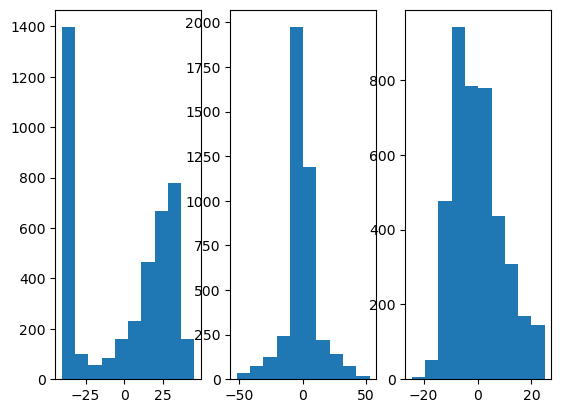

[ True  True  True ... False False False]


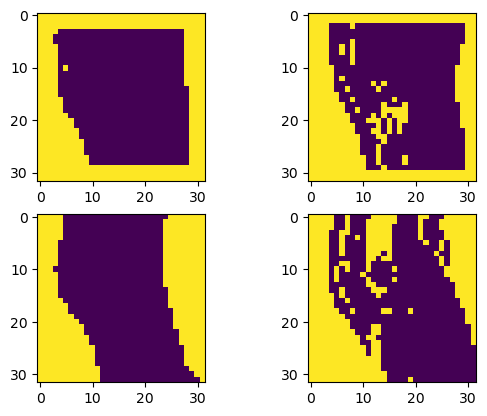

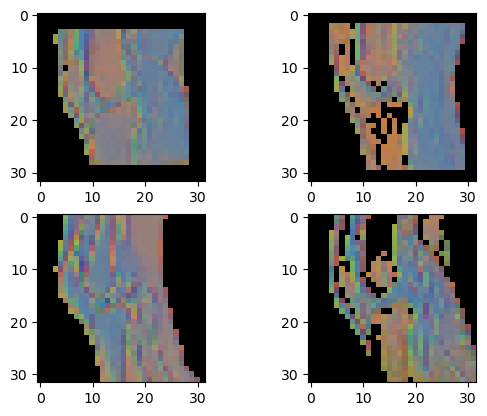

In [27]:
names,slice_nums,pixel_locations = case_names()
case_tensors,attentions = predict(names,slice_nums)

In [1]:
import numpy as np
import torch
import cv2
import os
import torchvision.transforms as T
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.nn as nn
import ast
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import zoom
from utils import preprocess_data
from PIL import Image
from sklearn.decomposition import PCA

case_path = "0000.npy"
MAX_PIXEL_VAL = 255
MEAN = 58.09
STD = 49.73
def preprocess_data(case_path, transform=None):
    series = np.load(case_path).astype(np.float32)
    series = zoom(series, (1,0.875,0.875))
    series = torch.tensor(np.stack((series,)*3, axis=1))
    
    # series = torch.tensor(series)

    if transform is not None:
        for i, slice in enumerate(series.split(1)):
            series[i] = transform(slice.squeeze())

    series = (series - series.min()) / (series.max() - series.min()) * MAX_PIXEL_VAL
    series = (series - MEAN) / STD
    return series

series = preprocess_data(case_path)
print(series.shape)

In [5]:
def visualize_attention(model, case_tensors, device="cuda"):
    case_num = len(case_tensors)
    case_tensors = case_tensors[:4,:,:,:].to(device)
    print(case_tensors.shape)
    with torch.no_grad():
        features_dict = model.forward_features(case_tensors)
        features = features_dict['x_norm_patchtokens']
        print(features.shape)
    
    patch_h = patch_w = 32 # 448/14=32
    features = features.reshape(4 * patch_h * patch_w, 1024)
    features = features.cpu().detach()
    pca = PCA(n_components=3)
    pca.fit(features)
    pca_features = pca.transform(features)

    # visualize PCA components for finding a proper threshold
    plt.subplot(1, 3, 1)
    plt.hist(pca_features[:, 0])
    plt.subplot(1, 3, 2)
    plt.hist(pca_features[:, 1])
    plt.subplot(1, 3, 3)
    plt.hist(pca_features[:, 2])
    plt.show()
    plt.close()

    # segment using the first component
    pca_features_bg = pca_features[:, 0] < 0
    print(pca_features_bg)
    pca_features_fg = ~pca_features_bg

    # plot the pca_features_bg
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
    plt.show()

    # PCA for only foreground patches
    pca_features_rem = pca.transform(features[pca_features_fg])
    for i in range(3):
        # pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
        # transform using mean and std, I personally found this transformation gives a better visualization
        pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

    pca_features_rgb = pca_features.copy()
    pca_features_rgb[pca_features_bg] = 0
    pca_features_rgb[pca_features_fg] = pca_features_rem

    pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(pca_features_rgb[i][..., ::-1])
    plt.savefig('features.png')
    plt.show()
    plt.close()
    return features

In [8]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to('cuda')
features = visualize_attention(model, series)

Using cache found in /home/domainHomes/tian/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([4, 3, 224, 224])


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

In [5]:
import torch 
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
dinov2_vitb14.lo

Using cache found in /home/domainHomes/tian/.cache/torch/hub/facebookresearch_dinov2_main


In [33]:
import torch 
z = []
x = torch.randn(2,4)
y = torch.randn(2,4)
z.append(x.unsqueeze(0))
z.append(y.unsqueeze(0))
z = torch.cat(z, dim=0)
print(z)

tensor([[[-0.7432,  0.8874,  0.5795,  0.3830],
         [ 0.0626,  1.8753, -0.9642, -0.1612]],

        [[ 0.4104,  0.9546, -0.5949,  1.3797],
         [-0.0591, -0.8850,  0.7654, -0.7076]]])


In [4]:
import torch
import torch.nn as nn
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
model.head = nn.Linear(768,4)
print(model)

Using cache found in /home/domainHomes/tian/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [6]:
import torch

x = torch.tensor([1,2,3,4,5])
x[:3]

tensor([1, 2, 3])